# Exploration and training

### This part off the notebook will focus on the exploration off the data and attempts at fitting, training and feature engineering the model.

First we add the necessary dependencies and import the data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.preprocessing import LabelEncoder

# Load data from transform.ipynb outputs
X_train_raw = pd.read_csv('data/X_train_raw.csv')
X_test_raw = pd.read_csv('data/X_test_raw.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

# Load column lists
with open('data/num_vals.json', 'r') as f:
    num_vals = json.load(f)
with open('data/cat_vals.json', 'r') as f:
    cat_vals = json.load(f)

# Load preprocessor
preprocessor = joblib.load('data/preprocessor.joblib')

print(f"Training set: {X_train_raw.shape}")
print(f"Test set: {X_test_raw.shape}")
print(f"Target classes: {y_train.unique()}")

Training set: (3539, 36)
Test set: (885, 36)
Target classes: ['Graduate' 'Dropout' 'Enrolled']


In [2]:
# Transform data using the fitted preprocessor
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Transformed training shape: {X_train.shape}")
print(f"Transformed test shape: {X_test.shape}")
print(f"Label mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")

Transformed training shape: (3539, 251)
Transformed test shape: (885, 251)
Label mapping: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


## Baseline Models with GridSearchCV

Training simple classifiers to establish baseline performance before feature engineering.

In [3]:
# Decision Tree Classifier with GridSearchCV
dt_params = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train_encoded)

print(f"\nBest Decision Tree Parameters: {dt_grid.best_params_}")
print(f"Best CV F1 Score: {dt_grid.best_score_:.4f}")

# Evaluate on test set
dt_pred = dt_grid.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, dt_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, dt_pred, average='weighted'):.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1 Score: 0.7325
Test Accuracy: 0.7232
Test F1 Score: 0.7242


In [4]:
# Logistic Regression with GridSearchCV
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg'],
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train_encoded)

print(f"\nBest Logistic Regression Parameters: {lr_grid.best_params_}")
print(f"Best CV F1 Score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
lr_pred = lr_grid.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, lr_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, lr_pred, average='weighted'):.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Logistic Regression Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 Score: 0.7689
Test Accuracy: 0.7684
Test F1 Score: 0.7577


In [5]:
# K-Nearest Neighbors with GridSearchCV
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train, y_train_encoded)

print(f"\nBest KNN Parameters: {knn_grid.best_params_}")
print(f"Best CV F1 Score: {knn_grid.best_score_:.4f}")

# Evaluate on test set
knn_pred = knn_grid.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, knn_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, knn_pred, average='weighted'):.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best CV F1 Score: 0.6990
Test Accuracy: 0.7186
Test F1 Score: 0.6986


In [6]:
# Baseline Results Summary
baseline_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'KNN'],
    'Best CV F1': [dt_grid.best_score_, lr_grid.best_score_, knn_grid.best_score_],
    'Test Accuracy': [
        accuracy_score(y_test_encoded, dt_pred),
        accuracy_score(y_test_encoded, lr_pred),
        accuracy_score(y_test_encoded, knn_pred)
    ],
    'Test F1': [
        f1_score(y_test_encoded, dt_pred, average='weighted'),
        f1_score(y_test_encoded, lr_pred, average='weighted'),
        f1_score(y_test_encoded, knn_pred, average='weighted')
    ]
})

print("="*60)
print("BASELINE RESULTS SUMMARY")
print("="*60)
print(baseline_results.to_string(index=False))
print("="*60)

BASELINE RESULTS SUMMARY
              Model  Best CV F1  Test Accuracy  Test F1
      Decision Tree    0.732518       0.723164 0.724158
Logistic Regression    0.768944       0.768362 0.757722
                KNN    0.698999       0.718644 0.698611


## Feature Engineering

Creating new features based on domain knowledge and analyzing feature importance.

Top 20 Most Important Features (Decision Tree):
                                    feature  importance
   num__Curricular units 2nd sem (approved)    0.443998
             cat__Tuition fees up to date_0    0.040635
   num__Curricular units 1st sem (approved)    0.040090
   num__Curricular units 1st sem (enrolled)    0.038527
num__Curricular units 2nd sem (evaluations)    0.036847
                       num__Admission grade    0.029883
                     num__Age at enrollment    0.028857
num__Curricular units 1st sem (evaluations)    0.027231
                                   num__GDP    0.022878
      num__Curricular units 2nd sem (grade)    0.022733
        num__Previous qualification (grade)    0.021903
                        num__Inflation rate    0.020491
             cat__Tuition fees up to date_1    0.015626
   num__Curricular units 2nd sem (enrolled)    0.014942
                     num__Unemployment rate    0.012066
                           cat__Course_9853    0.011838


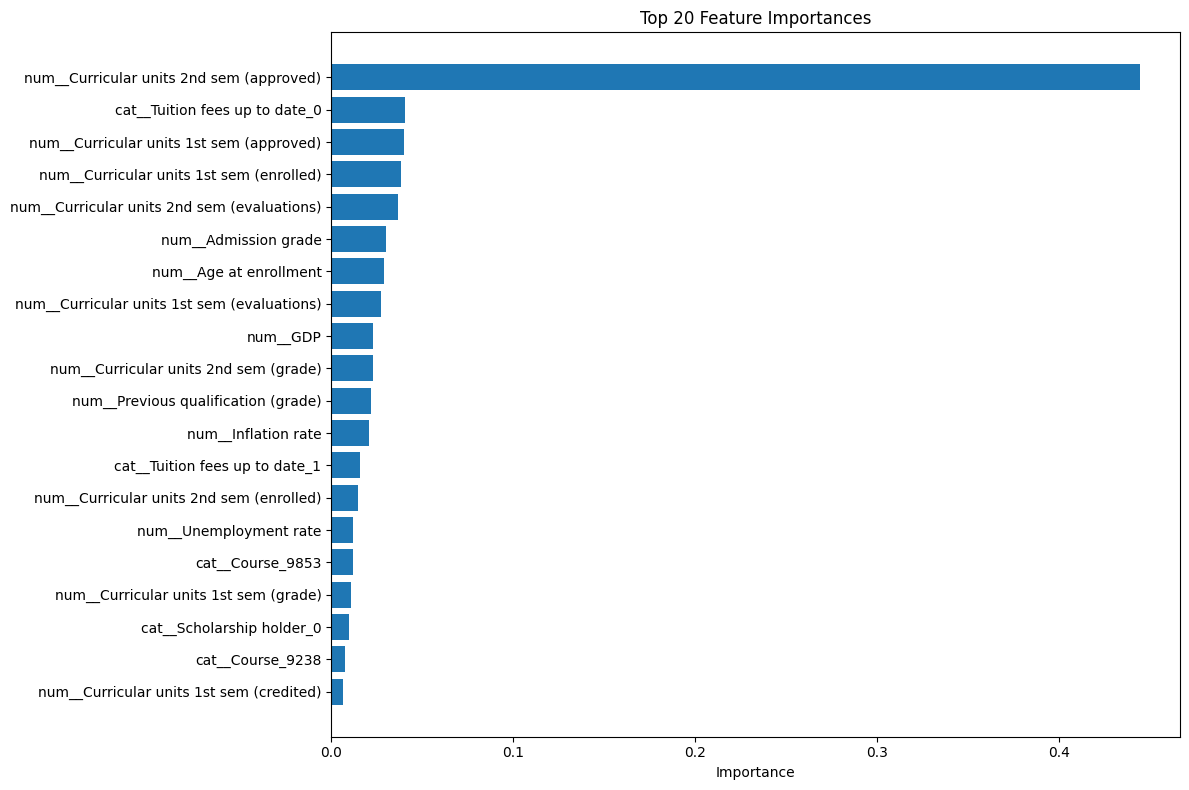

In [7]:
# Feature Importance from Decision Tree
feature_names = preprocessor.get_feature_names_out()
importances = dt_grid.best_estimator_.feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features (Decision Tree):")
print(importance_df.head(20).to_string(index=False))

# Visualize top features
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values)
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Create engineered features from raw data
def engineer_features(df):
    """Create new features based on domain knowledge."""
    df_new = df.copy()
    
    # Academic performance aggregates
    df_new['total_approved'] = (
        df['Curricular units 1st sem (approved)'] + 
        df['Curricular units 2nd sem (approved)']
    )
    
    df_new['total_enrolled'] = (
        df['Curricular units 1st sem (enrolled)'] + 
        df['Curricular units 2nd sem (enrolled)']
    )
    
    # Approval rate (handle division by zero)
    df_new['approval_rate'] = np.where(
        df_new['total_enrolled'] > 0,
        df_new['total_approved'] / df_new['total_enrolled'],
        0
    )
    
    # Grade average
    df_new['avg_grade'] = (
        df['Curricular units 1st sem (grade)'] + 
        df['Curricular units 2nd sem (grade)']
    ) / 2
    
    # Semester improvement (2nd sem - 1st sem grades)
    df_new['grade_improvement'] = (
        df['Curricular units 2nd sem (grade)'] - 
        df['Curricular units 1st sem (grade)']
    )
    
    # Approval improvement
    df_new['approval_improvement'] = (
        df['Curricular units 2nd sem (approved)'] - 
        df['Curricular units 1st sem (approved)']
    )
    
    # Credited units ratio
    df_new['total_credited'] = (
        df['Curricular units 1st sem (credited)'] + 
        df['Curricular units 2nd sem (credited)']
    )
    
    # Without evaluations (potential risk indicator)
    df_new['total_without_eval'] = (
        df['Curricular units 1st sem (without evaluations)'] + 
        df['Curricular units 2nd sem (without evaluations)']
    )
    
    # Age group (binned)
    df_new['age_group'] = pd.cut(
        df['Age at enrollment'], 
        bins=[0, 20, 25, 30, 100], 
        labels=[0, 1, 2, 3]
    ).astype(int)
    
    return df_new

# Apply feature engineering
X_train_fe = engineer_features(X_train_raw)
X_test_fe = engineer_features(X_test_raw)

print(f"Original features: {X_train_raw.shape[1]}")
print(f"After engineering: {X_train_fe.shape[1]}")
print(f"\nNew features added:")
new_cols = [c for c in X_train_fe.columns if c not in X_train_raw.columns]
for col in new_cols:
    print(f"  - {col}")

Original features: 36
After engineering: 45

New features added:
  - total_approved
  - total_enrolled
  - approval_rate
  - avg_grade
  - grade_improvement
  - approval_improvement
  - total_credited
  - total_without_eval
  - age_group


In [9]:
# Update column lists with new features
num_vals_fe = num_vals + [
    'total_approved', 'total_enrolled', 'approval_rate', 'avg_grade',
    'grade_improvement', 'approval_improvement', 'total_credited', 
    'total_without_eval', 'age_group'
]

# Create new preprocessor with updated columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline_fe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scale', StandardScaler())
])

cat_pipeline_fe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_fe = ColumnTransformer([
    ('num', num_pipeline_fe, num_vals_fe),
    ('cat', cat_pipeline_fe, cat_vals)
])

# Transform feature-engineered data
X_train_fe_transformed = preprocessor_fe.fit_transform(X_train_fe)
X_test_fe_transformed = preprocessor_fe.transform(X_test_fe)

print(f"Feature-engineered training shape: {X_train_fe_transformed.shape}")
print(f"Feature-engineered test shape: {X_test_fe_transformed.shape}")

Feature-engineered training shape: (3539, 260)
Feature-engineered test shape: (885, 260)


## Feature Selection

Using SelectKBest to identify the most predictive features.

In [10]:
# Feature Selection using SelectKBest
# Test different k values to find optimal number of features
k_values = [50, 75, 100, 125, 150]
k_results = []

for k in k_values:
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_fe_transformed, y_train_encoded)
    X_test_selected = selector.transform(X_test_fe_transformed)
    
    # Quick evaluation with Decision Tree
    dt_temp = DecisionTreeClassifier(random_state=42, max_depth=10)
    cv_scores = cross_val_score(dt_temp, X_train_selected, y_train_encoded, cv=5, scoring='f1_weighted')
    
    k_results.append({
        'k': k,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    })
    print(f"k={k}: CV F1 = {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

k_results_df = pd.DataFrame(k_results)
best_k = k_results_df.loc[k_results_df['cv_f1_mean'].idxmax(), 'k']
print(f"\nBest k value: {int(best_k)}")

k=50: CV F1 = 0.7255 (+/- 0.0120)
k=75: CV F1 = 0.7279 (+/- 0.0100)
k=100: CV F1 = 0.7279 (+/- 0.0059)
k=125: CV F1 = 0.7243 (+/- 0.0094)
k=150: CV F1 = 0.7271 (+/- 0.0189)

Best k value: 75


In [11]:
# Apply best feature selection
selector_best = SelectKBest(f_classif, k=int(best_k))
X_train_final = selector_best.fit_transform(X_train_fe_transformed, y_train_encoded)
X_test_final = selector_best.transform(X_test_fe_transformed)

print(f"Final training shape: {X_train_final.shape}")
print(f"Final test shape: {X_test_final.shape}")

# Get selected feature names
feature_names_fe = preprocessor_fe.get_feature_names_out()
selected_mask = selector_best.get_support()
selected_features = feature_names_fe[selected_mask]

print(f"\nSelected {len(selected_features)} features")

Final training shape: (3539, 75)
Final test shape: (885, 75)

Selected 75 features


## Re-train Models with Engineered Features

Comparing performance with feature engineering applied.

In [12]:
# Decision Tree with Feature Engineering
dt_grid_fe = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
dt_grid_fe.fit(X_train_final, y_train_encoded)

print(f"\nBest Decision Tree (FE) Parameters: {dt_grid_fe.best_params_}")
print(f"Best CV F1 Score: {dt_grid_fe.best_score_:.4f}")

dt_pred_fe = dt_grid_fe.predict(X_test_final)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, dt_pred_fe):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, dt_pred_fe, average='weighted'):.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Decision Tree (FE) Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1 Score: 0.7448
Test Accuracy: 0.7571
Test F1 Score: 0.7471


In [13]:
# Logistic Regression with Feature Engineering
lr_grid_fe = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
lr_grid_fe.fit(X_train_final, y_train_encoded)

print(f"\nBest Logistic Regression (FE) Parameters: {lr_grid_fe.best_params_}")
print(f"Best CV F1 Score: {lr_grid_fe.best_score_:.4f}")

lr_pred_fe = lr_grid_fe.predict(X_test_final)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, lr_pred_fe):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, lr_pred_fe, average='weighted'):.4f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Logistic Regression (FE) Parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 Score: 0.7682
Test Accuracy: 0.7684
Test F1 Score: 0.7563


In [14]:
# KNN with Feature Engineering
knn_grid_fe = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
knn_grid_fe.fit(X_train_final, y_train_encoded)

print(f"\nBest KNN (FE) Parameters: {knn_grid_fe.best_params_}")
print(f"Best CV F1 Score: {knn_grid_fe.best_score_:.4f}")

knn_pred_fe = knn_grid_fe.predict(X_test_final)
print(f"Test Accuracy: {accuracy_score(y_test_encoded, knn_pred_fe):.4f}")
print(f"Test F1 Score: {f1_score(y_test_encoded, knn_pred_fe, average='weighted'):.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best KNN (FE) Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best CV F1 Score: 0.7302
Test Accuracy: 0.7480
Test F1 Score: 0.7328


In [15]:
# Compare Baseline vs Feature Engineered Results
comparison_results = pd.DataFrame({
    'Model': ['Decision Tree', 'Decision Tree (FE)', 
              'Logistic Regression', 'Logistic Regression (FE)',
              'KNN', 'KNN (FE)'],
    'CV F1': [
        dt_grid.best_score_, dt_grid_fe.best_score_,
        lr_grid.best_score_, lr_grid_fe.best_score_,
        knn_grid.best_score_, knn_grid_fe.best_score_
    ],
    'Test Accuracy': [
        accuracy_score(y_test_encoded, dt_pred),
        accuracy_score(y_test_encoded, dt_pred_fe),
        accuracy_score(y_test_encoded, lr_pred),
        accuracy_score(y_test_encoded, lr_pred_fe),
        accuracy_score(y_test_encoded, knn_pred),
        accuracy_score(y_test_encoded, knn_pred_fe)
    ],
    'Test F1': [
        f1_score(y_test_encoded, dt_pred, average='weighted'),
        f1_score(y_test_encoded, dt_pred_fe, average='weighted'),
        f1_score(y_test_encoded, lr_pred, average='weighted'),
        f1_score(y_test_encoded, lr_pred_fe, average='weighted'),
        f1_score(y_test_encoded, knn_pred, average='weighted'),
        f1_score(y_test_encoded, knn_pred_fe, average='weighted')
    ]
})

print("="*70)
print("BASELINE vs FEATURE ENGINEERED COMPARISON")
print("="*70)
print(comparison_results.to_string(index=False))
print("="*70)

BASELINE vs FEATURE ENGINEERED COMPARISON
                   Model    CV F1  Test Accuracy  Test F1
           Decision Tree 0.732518       0.723164 0.724158
      Decision Tree (FE) 0.744777       0.757062 0.747097
     Logistic Regression 0.768944       0.768362 0.757722
Logistic Regression (FE) 0.768226       0.768362 0.756301
                     KNN 0.698999       0.718644 0.698611
                KNN (FE) 0.730177       0.748023 0.732847


## Save Artifacts for Next Notebook

Saving models, data, and preprocessing objects for hyperparameter tuning.

In [16]:
# Save feature-engineered data
np.save('data/X_train_fe.npy', X_train_final)
np.save('data/X_test_fe.npy', X_test_final)
np.save('data/y_train_encoded.npy', y_train_encoded)
np.save('data/y_test_encoded.npy', y_test_encoded)

# Save preprocessor and selector
joblib.dump(preprocessor_fe, 'data/preprocessor_fe.joblib')
joblib.dump(selector_best, 'data/selector.joblib')
joblib.dump(le, 'data/label_encoder.joblib')

# Save feature-engineered raw data for reference
X_train_fe.to_csv('data/X_train_fe_raw.csv', index=False)
X_test_fe.to_csv('data/X_test_fe_raw.csv', index=False)

# Save baseline results
baseline_results.to_csv('data/baseline_results.csv', index=False)
comparison_results.to_csv('data/comparison_results.csv', index=False)

# Save best baseline models
joblib.dump(dt_grid_fe.best_estimator_, 'data/best_dt.joblib')
joblib.dump(lr_grid_fe.best_estimator_, 'data/best_lr.joblib')
joblib.dump(knn_grid_fe.best_estimator_, 'data/best_knn.joblib')

# Save updated column lists
with open('data/num_vals_fe.json', 'w') as f:
    json.dump(num_vals_fe, f)

print("All artifacts saved successfully!")
print("\nSaved files:")
print("  - data/X_train_fe.npy, X_test_fe.npy (transformed data)")
print("  - data/y_train_encoded.npy, y_test_encoded.npy (encoded labels)")
print("  - data/preprocessor_fe.joblib (feature engineering preprocessor)")
print("  - data/selector.joblib (feature selector)")
print("  - data/label_encoder.joblib (target encoder)")
print("  - data/best_dt.joblib, best_lr.joblib, best_knn.joblib (baseline models)")
print("  - data/baseline_results.csv, comparison_results.csv (results)")

All artifacts saved successfully!

Saved files:
  - data/X_train_fe.npy, X_test_fe.npy (transformed data)
  - data/y_train_encoded.npy, y_test_encoded.npy (encoded labels)
  - data/preprocessor_fe.joblib (feature engineering preprocessor)
  - data/selector.joblib (feature selector)
  - data/label_encoder.joblib (target encoder)
  - data/best_dt.joblib, best_lr.joblib, best_knn.joblib (baseline models)
  - data/baseline_results.csv, comparison_results.csv (results)
